In [1]:
import numpy as np
import datetime
import xarray as xr
import pandas as pd
import sys, glob, os, re, subprocess
import matplotlib
import matplotlib.pyplot as plt
import re

def parse_metrics_to_dataframe(input_file):
    # Initialize an empty list to store the rows of the DataFrame
    rows = []

    # Define the pattern to extract the date and time
    date_pattern = re.compile(r"\w{3} \d{2} \w{3} \d{4} \d{2}:\d{2}:\d{2} [AP]M \w{3}")

    # Read the input file
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    # Initialize an empty dictionary to store the current block of metrics
    current_block = {}

    # Iterate through the lines in the file
    for line in lines:
        date_match = date_pattern.match(line)
        if date_match:
            if current_block:
                # Append the current block to rows
                rows.append(current_block)
                current_block = {}
            current_block['datetime'] = date_match.group()
        else:
            parts = line.split('\t')
            if len(parts) == 2:
                value, metric = parts
                metric = metric.strip('#').strip()
                current_block[metric] = float(value)
    
    # Append the last block if any
    if current_block:
        rows.append(current_block)
    
    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(rows)
    
    return df


# load data

## lse/sse

In [2]:
# load info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

In [3]:
# input/out and iteration information
iternum = 4
inpath_moasmo = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/'
outpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out'

In [21]:
# LSE metrics
outfile = f'{outpath}/LSE_627basin_CTSM_4iter_optmz_metrics.csv.gz'
if os.path.isfile(outfile):
    df_lse_metric = pd.read_csv(outfile, compression='gzip')

best_kge_lse = np.zeros(len(df_info))
defa_kge =  np.zeros(len(df_info))
for i in range(len(df_info)):
    best_kge_lse[i] = np.nanmax(df_lse_metric[df_lse_metric['basin']==i]['kge'].values)
    defa_kge[i] = df_lse_metric[df_lse_metric['basin']==i]['kge'].values[0]

In [8]:
# SSE metrics
outfile = f'{outpath}/SSE_627basin_CTSM_4iter_optmz_metrics.csv.gz'
if os.path.isfile(outfile):
    df_sse_metric = pd.read_csv(outfile, compression='gzip')

best_kge_sse = np.zeros(len(df_info))
for i in range(len(df_info)):
    best_kge_sse[i] = np.nanmax(df_sse_metric[df_sse_metric['basin']==i]['kge'].values)

## ostrich results

In [34]:
df_calib_kge = []

for i in range(0, 627, 5):
    inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich_kge/'
    infile = f'{inpath}/level1_{i}_OSTRICHcalib/archive/PreserveBestModel/trial_stats_allrecords.txt'
    df_calib_kge.append(parse_metrics_to_dataframe(infile))

trials = [len(i) for i in df_calib_kge]
print('Mean trial number for each basin:', np.mean(trials))


# For KGE calibration, best metrics
tarmetrics = ['streamflow_KGE', 'streamflow_RMSE', 'streamflow_abserr', 'streamflow_maxmontherr', 'streamflow_mean2err']
calib_kge_metrics = np.zeros([len(df_calib_kge), 5])
for i in range(len(df_calib_kge)):
    dfi = df_calib_kge[i]
    indi = np.argmax(dfi['streamflow_KGE'].values)
    for j in range(len(tarmetrics)):
        calib_kge_metrics[i, j] = dfi.iloc[indi][tarmetrics[j]]

print('mean', np.nanmean(calib_kge_metrics,axis=0))
print('median', np.nanmedian(calib_kge_metrics,axis=0))

Mean trial number for each basin: 188.92857142857142
mean [ 0.42785176 11.4566021   5.51901245  7.2161206   6.3675665 ]
median [0.4874395 5.8147325 2.458752  2.5464375 2.618649 ]


# compare

In [32]:
print('ostrich median kge', np.nanmedian(calib_kge_metrics[:,0]))
print('lse median kge', np.nanmedian(best_kge_lse[::5]))
print('lse median kge', np.nanmedian(best_kge_sse[::5]))

ostrich median kge 0.48602999999999996
lse median kge 0.5336828804770497
lse median kge 0.5109181380665304


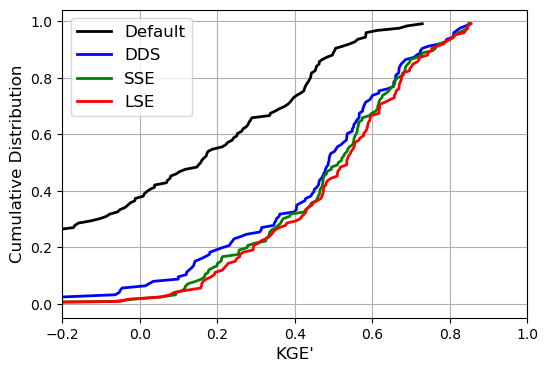

In [33]:
fx = np.arange(len(calib_kge_metrics[:,0]))/len(calib_kge_metrics[:,0])

plt.figure(figsize=(6, 4))  # Increase the size of the plot for better readability

plt.plot(np.sort(defa_kge[::5]), fx, label='Default', linewidth=2, color='k')
plt.plot(np.sort(calib_kge_metrics[:, 0]), fx, label='DDS', linewidth=2, color='blue')
plt.plot(np.sort(best_kge_sse[::5]), fx, label='SSE', linewidth=2, color='green')
plt.plot(np.sort(best_kge_lse[::5]), fx, label='LSE', linewidth=2, color='red')

plt.xlabel("KGE'", fontsize=12)
plt.ylabel('Cumulative Distribution', fontsize=12)

plt.xlim(-0.2, 1)

plt.grid(True)
plt.legend(fontsize=12)

# Show the plot
plt.savefig('KGE_CDF_LSE_SSE_DDS.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()